<a href="https://colab.research.google.com/github/mittshah2/Music-Generation/blob/main/music_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import os
import music21 as m21
import json
import tensorflow as tf
import numpy as np
from tqdm import tqdm

In [41]:
ACCEPTABLE_DURATIONS = [
    0.25, # 16th note
    0.5, # 8th note
    0.75,
    1.0, # quarter note
    1.5,
    2, # half note
    3,
    4 # whole note
]
SEQUENCE_LENGTH=64

In [ ]:
def convert(path):
  songs=[]
  for name in os.listdir(path):
    if name[-3:]=='krn':
      song=m21.converter.parse(os.path.join(path,name))
      songs.append(song)
  return songs

In [ ]:
def has_acceptable_durations(song, acceptable_durations):
    for note in song.flat.notesAndRests:
      if note.duration.quarterLength not in acceptable_durations:
        return False
    return True

In [ ]:
def transpose(song):
  parts=song.getElementsByClass(m21.stream.Part)
  measure_part0=parts[0].getElementsByClass(m21.stream.Measure)
  key=measure_part0[0][4]

  if not isinstance(key,m21.key.Key):
    key=song.analyze("key")

  if key.mode == 'major':
    interval=m21.interval.Interval(key.tonic,m21.pitch.Pitch('C'))
  elif key.mode == 'minor':
    interval=m21.interval.Interval(key.tonic,m21.pitch.Pitch('A'))

  transposed=song.transpose(interval)

  return transposed


In [ ]:
def encode_song(song, time_step=0.25):

    encoded_song = []

    for event in song.flat.notesAndRests:

        # handle notes
        if isinstance(event, m21.note.Note):
            symbol = event.pitch.midi # 60
        # handle rests
        elif isinstance(event, m21.note.Rest):
            symbol = "r"

        # convert the note/rest into time series notation
        steps = int(event.duration.quarterLength / time_step)
        for step in range(steps):
            if step == 0:
                encoded_song.append(symbol)
            else:
                encoded_song.append("_")

    # cast encoded song to str
    encoded_song = " ".join(map(str, encoded_song))

    return encoded_song

In [ ]:
def preprocess(path,save_path):
  print("Loading...")
  songs=convert(path)
  print(f"Loaded {len(songs)} songs")

  for i,song in enumerate(songs):
    # print(has_acceptable_duration(song,ACCEPTABLE_DURATIONS))
    if not has_acceptable_durations(song,ACCEPTABLE_DURATIONS):
      continue
    
    song=transpose(song)

    encoded_song=encode_song(song)

    save_path1=os.path.join(save_path,str(i)+'.txt')

    with open(save_path1,'w') as fp:
      fp.write(encoded_song)


In [ ]:
preprocess('/content/drive/My Drive/music generation/data/variant','/content/drive/My Drive/music generation/text_files')

Loading...
Loaded 26 songs


In [ ]:
def create_single_file(path,save_path,sequence_length):

  new_song_deliminiter="/ "*sequence_length
  songs=""

  for name in os.listdir(path):
    with open(os.path.join(path,name),'r') as fp:
      song=fp.read()
    songs=songs+song+new_song_deliminiter
  
  songs=songs[:-1]

  with open(save_path,'w') as fp:
    fp.write(songs)
  
  return songs

In [ ]:
songs=create_single_file('/content/drive/My Drive/music generation/text_files','/content/drive/My Drive/music generation/dataset.txt',SEQUENCE_LENGTH)

In [1]:
with open('/content/drive/My Drive/music generation/dataset.txt') as fp:
  songs=fp.read()

In [2]:
def create_mapping(songs,mapping_path):
  mappings={}
  
  songs=songs.split()
  vocab=list(set(songs))

  for i,symbol in enumerate(vocab):
    mappings[symbol]=i

  with open(mapping_path,'w') as fp:
    json.dump(mappings,fp)

In [7]:
create_mapping(songs,'/content/drive/My Drive/music generation/mapping.json')

In [8]:
def map_to_int(json_path,songs):
  with open(json_path,'r') as fp:
    mappings=json.load(fp)
  
  int_songs=[]

  songs=songs.split()

  for symbol in songs:
    int_songs.append(mappings[symbol])
  
  return int_songs

In [9]:
def generate_training_sequences(sequence_length):

  int_songs=map_to_int('/content/drive/My Drive/music generation/mapping.json',songs)

  num_sequence=len(int_songs)-sequence_length


  inputs=[]
  targets=[]

  for i in range(num_sequence-1):
    inputs.append(int_songs[i:i+sequence_length])
    targets.append(int_songs[i+sequence_length+1])

  vocab_size=len(set(int_songs))

  inputs=tf.keras.utils.to_categorical(inputs,num_classes=vocab_size)
  targets=tf.keras.utils.to_categorical(targets,num_classes=vocab_size)
    
  return inputs,targets

In [15]:
input,target=generate_training_sequences(SEQUENCE_LENGTH)

In [16]:
input.shape #no of sequence,sequence length,vocab size

(3321, 64, 22)

In [11]:
def build_model(vocab_size):
  input=tf.keras.layers.Input(shape=[None,vocab_size])
  x=tf.keras.layers.LSTM(256,return_sequences=True)(input)
  x=tf.keras.layers.LSTM(256)(x)
  x=tf.keras.layers.Dropout(0.25)(x)
  x=tf.keras.layers.Dense(vocab_size,activation='softmax')(x)

  model=tf.keras.Model(inputs=input,outputs=x)
  model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(lr=1e-3),metrics=['accuracy'])
  return model

In [28]:
model=build_model(input.shape[2])
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, 22)]        0         
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 256)         285696    
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 22)                5654      
Total params: 816,662
Trainable params: 816,662
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(input,target,batch_size=64,epochs=64)

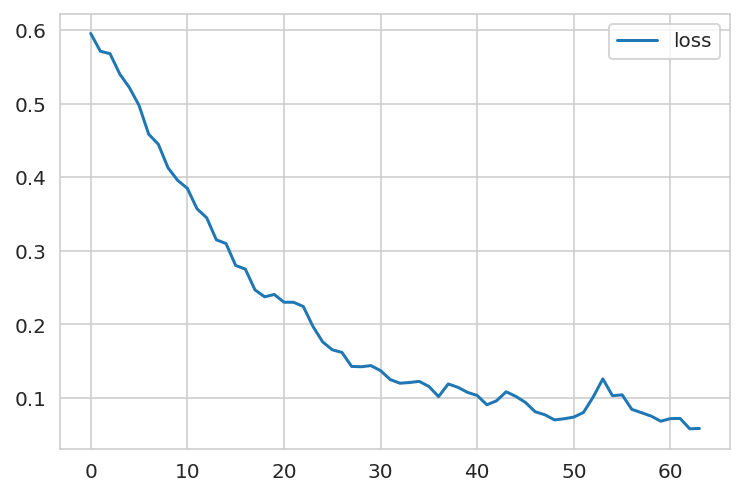

In [34]:
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
loss=pd.DataFrame(model.history.history)
loss[['loss']].plot()

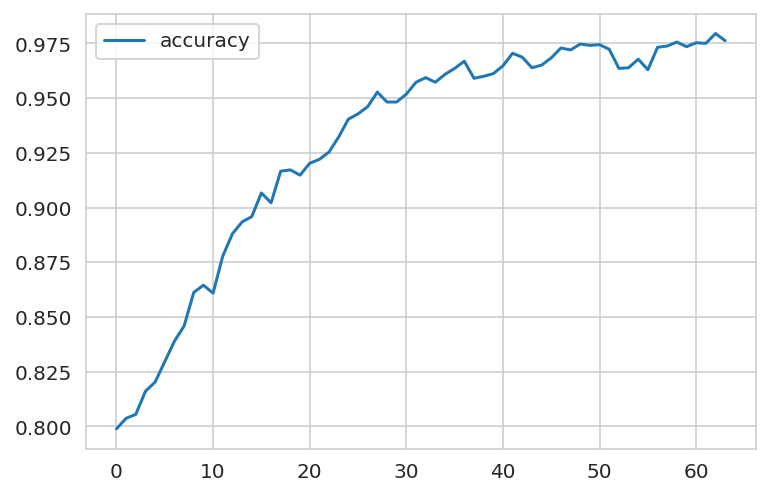

In [37]:
loss[['accuracy']].plot()

In [38]:
model.save('/content/drive/My Drive/music generation/model.h5')

In [88]:
class MelodyGenerator:

  def __init__(self):
    self.model_path='/content/drive/My Drive/music generation/model.h5'
    self.model=tf.keras.models.load_model(self.model_path)

    with open('/content/drive/My Drive/music generation/mapping.json') as fp:
      self.mapping=json.load(fp)
    
    self.start_symbols=['/']*SEQUENCE_LENGTH

  def sample_with_temp(self,prob,temp):
    pred=np.log(prob)/temp
    pred=np.exp(pred)/np.sum(np.exp(pred))

    choice=range(len(pred))

    return np.random.choice(choice,p=pred)


  def generate(self,seed,num_steps,max_sequence_length,temp):

    seed=seed.split()
    melody=seed

    seed=self.start_symbols+seed

    seed=[self.mapping[sym] for sym in seed]

    reverse_mapping={}
    for i,j in self.mapping.items():
      reverse_mapping[j]=i
   
    for _ in range(num_steps):
      seed=seed[-max_sequence_length:]
      one_hot_seed=tf.keras.utils.to_categorical(seed,num_classes=len(self.mapping))
      one_hot_seed=one_hot_seed[np.newaxis,...]

      prob=model.predict(one_hot_seed)[0]

      output_int=self.sample_with_temp(prob,temp)
      seed.append(output_int)

      out_sym=reverse_mapping[output_int]

      if out_sym=='/':
        break
      else:
        melody.append(out_sym)
      
    return melody
  
  def save(self,melody,step_duration=0.25,format='midi'):

    stream=m21.stream.Stream()

    start_symbol=None
    step_counter=1
    for i, symbol in enumerate(melody):

      if symbol != "_" or i + 1 == len(melody):

           
        if start_symbol is not None:

          quarter_length_duration = step_duration * step_counter # 0.25 * 4 = 1

              
          if start_symbol == "r":
            m21_event = m21.note.Rest(quarterLength=quarter_length_duration)

                
          else:
            m21_event = m21.note.Note(int(start_symbol), quarterLength=quarter_length_duration)

          stream.append(m21_event)
    
          step_counter = 1

        start_symbol = symbol

      else:
        step_counter += 1

       
    stream.write(format, '/content/drive/My Drive/music generation/music.midi')



In [89]:
m=MelodyGenerator()
seed='76 _ _ _ _ _ 74 _ 72 _'
melody=m.generate(seed,500,64,0.7)
m.save(melody)